<a href="https://colab.research.google.com/github/donaldziff/kgqa-ucb-210/blob/main/V2_Experimental_Text_Generation_with_T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing the required packages

In [ ]:
!pip install transformers
!pip install sentencepiece
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Importing required libraries

In [ ]:
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')

#Log into hugging face

## Preprocess the data

In [ ]:
import urllib.request
import zipfile
url = 'https://gitlab.com/shimorina/webnlg-dataset/-/archive/master/webnlg-dataset-master.zip?path=release_v3.0/en/train'
urllib.request.urlretrieve(url, 'web.zip')
with zipfile.ZipFile('web.zip', 'r') as zip_ref:
    zip_ref.extractall('web')
import glob
import os
import re
import xml.etree.ElementTree as ET
import pandas as pd
files = glob.glob("/content/web/webnlg-dataset-master-release_v3.0-en-train/release_v3.0/en/train/**/*.xml", recursive=True)
triple_re=re.compile('(\d)triples')
data_dct={}
for file in files:
    tree = ET.parse(file)
    root = tree.getroot()
    triples_num=int(triple_re.findall(file)[0])
    for sub_root in root:
        for ss_root in sub_root:
            strutured_master=[]
            unstructured=[]
            for entry in ss_root:
                unstructured.append(entry.text)
                strutured=[triple.text for triple in entry]
                strutured_master.extend(strutured)
            unstructured=[i for i in unstructured if i.replace('\n','').strip()!='' ]
            strutured_master=strutured_master[-triples_num:]
            strutured_master_str=(' && ').join(strutured_master)
            data_dct[strutured_master_str]=unstructured
mdata_dct={"prefix":[], "input_text":[], "target_text":[]}
for st,unst in data_dct.items():
    for i in unst:
        mdata_dct['prefix'].append('AskWiki NLG: ')
        mdata_dct['input_text'].append(st)
        mdata_dct['target_text'].append(i)


df=pd.DataFrame(mdata_dct)
df.to_csv('webNLG2020_train.csv')

In [ ]:
df[df['target_text']=='The Aarhus is the airport of Aarhus, Denmark.']

,prefix,input_text,target_text
26262,AskWiki NLG:,"Aarhus_Airport | cityServed | ""Aarhus, Denmark""","The Aarhus is the airport of Aarhus, Denmark."


In [ ]:
df[df['target_text'].str.contains('Aarhus Airport')]

,prefix,input_text,target_text
1156,AskWiki NLG:,Aarhus_Airport | location | Tirstrup && Tirstr...,"Aarhus Airport is located in Tirstrup, Denmark."
1157,AskWiki NLG:,Aarhus_Airport | location | Tirstrup && Tirstr...,"The location of Aarhus Airport is Tirstrup, in..."
1158,AskWiki NLG:,Aarhus_Airport | location | Tirstrup && Tirstr...,Aarhus Airport is located in Tirstrup which is...
1159,AskWiki NLG:,Aarhus_Airport | location | Tirstrup && Tirstr...,"The location of Aarhus Airport is Tirstrup, pa..."
1160,AskWiki NLG:,Aarhus_Airport | location | Tirstrup && Tirstr...,"Aarhus Airport is located in Tirstrup, part of..."
...,...,...,...
29430,AskWiki NLG:,Aarhus_Airport | runwayLength | 2777.0 && Aarh...,Aarhus Airport is 25 meters above sea level wi...
29431,AskWiki NLG:,Aarhus_Airport | runwayLength | 2777.0 && Aarh...,Aktieselskab is the operating organisation for...
29433,AskWiki NLG:,Aarhus_Airport | runwayLength | 2777.0 && Aarh...,10R/28L is the runway name at Aarhus Airport. ...
29435,AskWiki NLG:,Aarhus_Airport | runwayLength | 2777.0 && Aarh...,Aarhus Lufthavn A/S is the operation organisat...


In [ ]:
train_df=pd.read_csv('webNLG2020_train.csv', index_col=[0])

In [ ]:
pd.set_option('display.max_columns', None)  

In [ ]:
train_df[train_df['input_text'].str.contains("hep")]

,prefix,input_text,target_text
6559,AskWiki NLG:,"Alan_Shepard | almaMater | ""NWC, M.A. 1957"" &&...","Alan Shepard, who was awarded the Distinguishe..."
6560,AskWiki NLG:,"Alan_Shepard | almaMater | ""NWC, M.A. 1957"" &&...",1957 NWC M.A. graduate Alan Shepard is a recip...
6561,AskWiki NLG:,"Alan_Shepard | almaMater | ""NWC, M.A. 1957"" &&...",Alan Shepard who graduated from NWC with an MA...
6562,AskWiki NLG:,Alan_Shepard | birthPlace | New_Hampshire && A...,"Born in New Hampshire, Alan Shepard got a dist..."
6563,AskWiki NLG:,Alan_Shepard | birthPlace | New_Hampshire && A...,"Alan Shepard, who was born in New Hampshire, w..."
...,...,...,...
34932,AskWiki NLG:,Alan_Shepard | mission | Apollo_14 && New_Hamp...,Alan Shepard was born in New Hampshire (whose ...
34968,AskWiki NLG:,Distinguished_Service_Medal_(United_States_Nav...,Alan Shepard was born in New Hampshire on 1923...
34969,AskWiki NLG:,Distinguished_Service_Medal_(United_States_Nav...,Alan Shepard who was born in New Hampshire on ...
35003,AskWiki NLG:,New_Hampshire | bird | Purple_finch && Disting...,"The U.S. Navy awarded Alan Shepard, who was bo..."


In [ ]:
train_df.head()

,prefix,input_text,target_text
0,AskWiki NLG:,103_Colmore_Row | architect | John_Madin && 10...,"Architect John Madin, designed 103 Colmore Row..."
1,AskWiki NLG:,103_Colmore_Row | architect | John_Madin && 10...,"John Madin designed 103 Colmore Row, Birmingha..."
2,AskWiki NLG:,103_Colmore_Row | architect | John_Madin && 10...,"103 Colmore Row located in Birmingham, England..."
3,AskWiki NLG:,103_Colmore_Row | architect | John_Madin && 10...,"103 Colmore Row, located at Colmore Row, was d..."
4,AskWiki NLG:,103_Colmore_Row | architect | John_Madin && 10...,John Madin is the architect of 103 Colmore Row...


In [ ]:
train_df=train_df.iloc[  :35000,:]

In [ ]:
train_df=train_df.sample(frac = 1)

In [ ]:
batch_size=8
num_of_batches=len(train_df)/batch_size
num_of_epochs=4

In [ ]:
num_of_batches=int(num_of_batches)

Checking for the GPU availability

In [ ]:
if torch.cuda.is_available():
    dev = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


## Loading the pretrained model and tokenizer

In [ ]:
# tokenizer = T5Tokenizer.from_pretrained('t5-large')
# model = T5ForConditionalGeneration.from_pretrained('t5-large', return_dict=True)
# #moving the model to device(GPU/CPU)
# model.to(dev)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

# some manual verification encoding code

In [ ]:
s=test_df['input_text'].values.astype('str').tolist()

In [ ]:
s

['American_Motors | subsidiary | Wheel_Horse && AMC_Matador | manufacturer | American_Motors']

In [ ]:
labelbatch

['The AMC Matador is made by American Motors and has The Wheel Horse Co. as its subsidiary.</s>']

In [ ]:
inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')

In [ ]:
inputbatch

{'input_ids': tensor([[ 1620, 18207,   517,    10,   797,   834,   329,    32,  5535,  1820,
         20438,  1820, 10707,   834,   566,   127,     7,    15,     3,   184,
           184,    71,  3698,   834,   329,   144,  7923,  1820,  4818,  1820,
           797,   834,   329,    32,  5535,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
inputbatch

{'input_ids': tensor([[  797,   834,   329,    32,  5535,  1820, 20438,  1820, 10707,   834,
           566,   127,     7,    15,     3,   184,   184,    71,  3698,   834,
           329,   144,  7923,  1820,  4818,  1820,   797,   834,   329,    32,
          5535,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
labelbatch

['The AMC Matador is made by American Motors and has The Wheel Horse Co. as its subsidiary.</s>']

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=512,return_tensors="pt")
labelbatch

{'input_ids': tensor([[3785,  834,   23,   26,    7,    1],
        [1388,  834, 2754,  157,    1,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])}

In [ ]:
seqtoseq=tokenizer.prepare_seq2seq_batch('The AMC Matador is made by American Motors and has The Wheel Horse Co. as its subsidiary.</s>',padding=True,max_length=512,return_tensors="pt")
seqtoseq

{'input_ids': tensor([[   37,    71,  3698,  5708,  7923,    19,   263,    57,   797,  5083,
             7,    11,    65,    37, 10707, 13538,   638,     5,    38,   165,
         20438,     5,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
labelbatch

{'input_ids': tensor([[107730,    454,  30185,      2, 250004,      1],
        [ 35743,    454,   1510,     92,      2, 250004]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1]])}

In [ ]:
item = {key: torch.tensor(val) for key, val in labelbatch.items()}

In [ ]:
item

{'input_ids': tensor([[   37,    71,  3698,  5708,  7923,    19,   263,    57,   797,  5083,
              7,    11,    65,    37, 10707, 13538,   638,     5,    38,   165,
          20438,     5,     1]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
from transformers import MBartTokenizer

In [ ]:

tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-en-ro")

In [ ]:
batch = tokenizer.prepare_seq2seq_batch(src_texts=['The AMC Matador is made by American Motors and has The Wheel Horse Co. as its subsidiary.</s>'], src_lang="en_XX")

In [ ]:
batch

{'input_ids': [[581, 62, 32557, 17466, 1846, 83, 7228, 390, 15672, 15366, 7, 136, 1556, 581, 169060, 151307, 1311, 5, 237, 6863, 57527, 6635, 5, 2, 2, 250004]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

## Initializing the Adafactor optimizer with parameter values suggested for t5

In [ ]:
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [ ]:

from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [ ]:
num_of_epochs=1

## Training the model

In [ ]:
#modified training code 
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):
    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = 'AskWiki NLG: '+row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'   
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors="pt")["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
    
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))

Running epoch: 1


Epoch: 1 , Running loss: 0.4964481146029064


## Plotting the loss over time

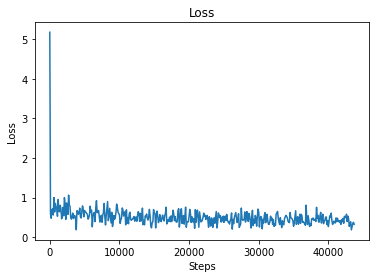

In [ ]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

#Push to huggingface

### We can figure out project and organization of models later on

In [ ]:
# #model.push_to_hub(repo_name="shrinivasbjoshi/w210AskWiki")

# model.push_to_hub(repo_url="https://huggingface.co/shrinivasbjoshi/w210AskWiki",repo_id="shrinivasbjoshi/w210AskWiki")

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/shrinivasbjoshi/w210AskWiki/commit/0eccdc4c9e9a14abab6b0b1fd9e68d67e0a1d3a7', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='0eccdc4c9e9a14abab6b0b1fd9e68d67e0a1d3a7', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
model.push_to_hub("W210T5NLGV2")

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shrinivasbjoshi/W210T5NLGV2/commit/72bedacbbacd07ce82e84697e9572952485483e3', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='72bedacbbacd07ce82e84697e9572952485483e3', pr_url=None, pr_revision=None, pr_num=None)

##W210 Testing

In [ ]:
from transformers import AutoModel



In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

In [ ]:
AskWiki_NLG = T5ForConditionalGeneration.from_pretrained('shrinivasbjoshi/W210T5NLGV2', return_dict=True)


In [ ]:
AskWiki_NLG.to(dev)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
input_ids = tokenizer.encode("AskWiki NLG: shrinivas | description | student && shrinivas | surname | joshi && shrinivas | student | UC Berkeley  && shrinivas | hair color | salt&pepper && shrinivas | age | 42  </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = AskWiki_NLG.generate(input_ids)
tokenizer.decode(outputs[0])

'<pad>UC Berkeley student shrinivas, who has the name joshi, is'

Self comments 
get t5 large to work on colab
figure out feature pruning on the other side of the pipeline if possible,otherwise this 2024 approach is ok for now 


how do we get blue and other score integrated in our NLG model 
also code for readability index 
what hyperparameter tuning you want to use for t5 model
what other data sets we can train our model on 
add pos embeddings ...right now we only have triple embeddings [this is how do we utilize wiki pairs dataset]


